In [1]:
import configparser
import numpy as np
from datetime import datetime

from tathu.io import spatialite
from tathu import visualizer
from tathu.utils import extractPeriods, file2timestamp, array2raster, getGeoT, geo2grid

from read_sipam_cappis import read_sipam_cappi


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [2]:
def get_files(filepath):
    """Return filelist according to a txt file"""
    filelist = open(filepath, "r")
    files = [line.strip() for line in filelist]
    return files

def read_radar(path, level, family_ext = False):
    """Reading radar data (specifically SIPAM CAPPIs)"""

    cappi = read_sipam_cappi(path)

    # Get original extent
    extent = [
        cappi.get_point_longitude_latitude()[0].min(),
        cappi.get_point_longitude_latitude()[1].max(),
        cappi.get_point_longitude_latitude()[0].max(),
        cappi.get_point_longitude_latitude()[1].min(),
    ]
    # print("original extent: ", extent)
    # Get grid original resolution
    gt = getGeoT(extent, 241, 241)
    # print(gt)
    if family_ext is not False:
        # print("family extent: ", family_ext)
        # Creating new extent
        upper_left_geo = (family_ext[0], family_ext[1])
        lower_right_geo = (family_ext[2], family_ext[3])
        upper_left_grid = geo2grid(upper_left_geo[0], upper_left_geo[1], gt)
        lower_right_grid = geo2grid(lower_right_geo[0], lower_right_geo[1], gt)
        min_lin = upper_left_grid[0]
        max_lin = lower_right_grid[0]
        min_col = upper_left_grid[1]
        max_col = lower_right_grid[1]
        slice_lon = slice(min_col, max_col)
        slice_lat = slice(min_lin, max_lin)
        # print("slice_lon: ", slice_lon)
        # print("slice_lat: ", slice_lat)
        extent = [
            cappi.get_point_longitude_latitude()[0][slice_lat, slice_lon].min(),
            cappi.get_point_longitude_latitude()[1][slice_lat, slice_lon].min(),
            cappi.get_point_longitude_latitude()[0][slice_lat, slice_lon].max(),
            cappi.get_point_longitude_latitude()[1][slice_lat, slice_lon].max(),
        ]
        # print("cappi new extent: ", extent)

        # Slice the data
        array = np.flipud(cappi.fields["DBZc"]["data"][level][slice_lat, slice_lon])
    else:
        array = np.flipud(cappi.fields["DBZc"]["data"][level])
    return array, extent

#### Loading sqlite database

In [3]:
# Setup informations to load systems from database
dbname = 'out/carol_20140509.sqlite'
table = 'systems'

In [4]:
# Load family
db = spatialite.Loader(dbname, table)

# Get systems
names = db.loadNames()

In [5]:
print(names)

['4e7d8741-b563-48de-8533-8494938b8858', 'f89bb416-83eb-4a90-ad05-70bed09e8699', 'd8d53213-8269-4e96-b772-7a870887df63', '6a7bce87-f47d-4a5c-a722-3444146dc4fd', '6dbc8553-15b2-4c18-bcb9-8f264fb56338', 'd37d38d6-35df-49cf-9537-4f5140aff525', '4e15fe94-bdea-4200-bb94-73c1f494d002', '73fe4017-6e99-44f2-bd7b-6e6982491984', 'ddd9d4e0-2147-440c-9d6c-2b85e7ff4000', 'cd7d270b-6ad6-47df-bacf-bf1b1fe73f4d', 'a5fd2804-83f3-441a-a17a-68d0f2e2e5fa', '1f54f9c4-1d90-47eb-b08c-7a6b7f436086', '51707333-2ab5-4887-bcfc-4ab62435cd7e', '85d4f5fe-e2d1-4f65-934d-e924007ae290', 'fdbd3627-94c2-4283-9678-5d4defdfb680', '5a750c24-9084-4c78-b16a-10fcccb5ecb2', '560f2a33-8a26-4e4d-b4fc-51891d407d18', '2eb8929c-f74f-44c9-ad81-60ce89203263', 'a9478576-37aa-47a1-a7ec-99adc9f1efb6', 'f4d79389-401e-4a45-8a36-0cbf3a572792', '716abe69-e3a6-492b-b5e0-936c996e3f66', 'b19d5ee3-0530-400d-8550-f4248d8eeee3', 'e573f5e0-7b79-4516-bbf3-dc3e71d81888', 'b596aa13-cf16-4f44-9f33-b3161ff1c836', 'c445230c-aba8-4c6b-9c21-4a921e5144d4',

#### Loading radar data

In [6]:
# Read config file and extract infos
params = configparser.ConfigParser(interpolation=None)
params.read("/home/camila/git/tathu/sipam-tracking/config_sipam.ini")

# Get input data parameters
data_in = params.get("input", "data_in")
date_regex = params.get("input", "date_regex")
date_format = params.get("input", "date_format")
level = int(params.get("input", "level_index"))
# Get tracking parameters
timeout = float(params.get("tracking_parameters", "timeout"))

# Get files
# files = get_files(data_in)

# Extracting periods
# periods = extractPeriods(files, timeout, date_regex, date_format)[0]

# Extracting timestamps
# timestamps = []
# for period in periods:
#     timestamps.append(file2timestamp(period, date_regex, date_format))

### Animação por família
Funciona, mas figura com polígonos está com escala de cor estranha

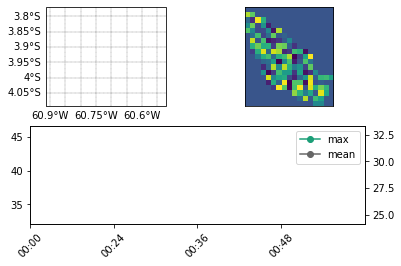

In [7]:
# Load first
family = db.load(names[0], ['max', 'mean', 'std', 'count'])

# Animation
aniview = visualizer.AnimationMap(family, ['max', 'mean'])
aniview.show()

aniview.save("out/test_dry_season_fam0.mp4")

### Histórico por família


/home/camila/miniconda3/envs/env-tathu/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


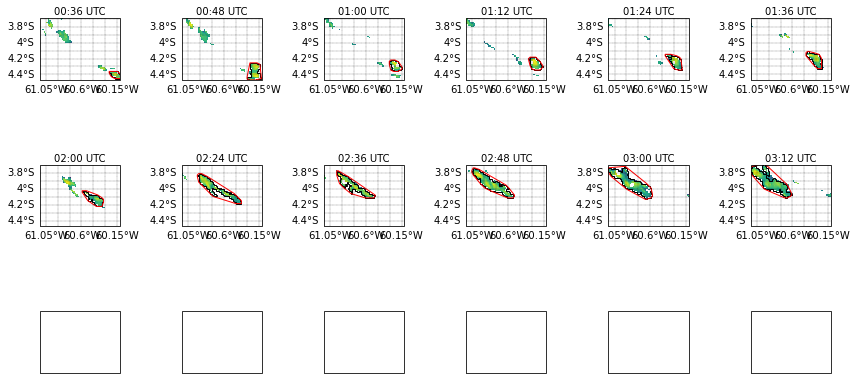

In [8]:
# Load a family
family = db.load(names[3], ['max', 'mean', 'std', 'count'])

# Get timestamps of radar families
radar_files = [("/home/camila/git/amazon-storms-aerosols/data/radar/sipam_manaus/arm_cappi/2014-05/20140509/sbmn_cappi_" + datetime.strftime(i, date_format) + ".nc") for i in family.getTimestamps()]
radar_data = [read_radar(i, level, family.getExtent())[0] for i in radar_files]
radar_extent = read_radar(radar_files[0], level, family.getExtent())[1]

hisview = visualizer.SystemHistoryView(family, radar_data, radar_extent)
hisview.show()


In [ ]:
x = read_radar("/home/camila/git/amazon-storms-aerosols/data/radar/sipam_manaus/arm_cappi/2014-05/20140509/sbmn_cappi_20140509_114801.nc", level)[0]

import matplotlib.pyplot as plt

plt.imshow(x)

In [ ]:
extent